## Introducción

En este cuaderno vamos a ver cómo construir un modelo de credit scoring clásico usando Python.

**Contenido:**

&emsp;[Introducción](#Introducci%C3%B3n)<br>
&emsp;[0. Setup de librerías y funciones](#0.-Setup-de-librer%C3%ADas-y-funciones)<br>
&emsp;[1. Carga de Datos y Análisis Exploratorio](#1.-Carga-de-Datos-y-An%C3%A1lisis-Exploratorio)<br>
&emsp;&emsp;[Exploración inicial](#Exploraci%C3%B3n-inicial)<br>
&emsp;&emsp;[Asignación de Roles](#Asignaci%C3%B3n-de-Roles)<br>
&emsp;&emsp;&emsp;[Target](#Target)<br>
&emsp;&emsp;&emsp;[Variables discretas](#Variables-discretas)<br>
&emsp;&emsp;&emsp;[Variables continuas](#Variables-continuas)<br>
&emsp;&emsp;&emsp;[Variables categóricas](#Variables-categ%C3%B3ricas)<br>
&emsp;&emsp;[Partición en Entrenamiento y Prueba](#Partici%C3%B3n-en-Entrenamiento-y-Prueba)<br>
&emsp;&emsp;[Análisis bivariados](#An%C3%A1lisis-bivariados)<br>
&emsp;&emsp;&emsp;[Discrete](#Discrete)<br>
&emsp;&emsp;&emsp;[Continuas](#Continuas)<br>
&emsp;&emsp;&emsp;[Categóricas](#Categ%C3%B3ricas)<br>
&emsp;&emsp;&emsp;[Gráficos bivariados para continuas](#Gr%C3%A1ficos-bivariados-para-continuas)<br>
&emsp;&emsp;&emsp;[Gráficos bivariados para categóricas](#Gr%C3%A1ficos-bivariados-para-categ%C3%B3ricas)<br>
&emsp;&emsp;[Identificación de variables no predictoras](#Identificaci%C3%B3n-de-variables-no-predictoras)<br>
&emsp;[2. ML Pipelines](#2.-ML-Pipelines)<br>
&emsp;&emsp;[Pipeline de Selección básica](#Pipeline-de-Selecci%C3%B3n-b%C3%A1sica)<br>
&emsp;&emsp;&emsp;[Exploración de selección de variables](#Exploraci%C3%B3n-de-selecci%C3%B3n-de-variables)<br>
&emsp;&emsp;[Pipeline de Modelado](#Pipeline-de-Modelado)<br>
&emsp;&emsp;[Construcción del modelo ALL](#Construcci%C3%B3n-del-modelo-ALL)<br>
&emsp;&emsp;[Exploración de transformaciones](#Exploraci%C3%B3n-de-transformaciones)<br>
&emsp;&emsp;[Exploración de selección de variables](#Exploraci%C3%B3n-de-selecci%C3%B3n-de-variables)<br>
&emsp;[3. Resumen del Entrenamiento](#3.-Resumen-del-Entrenamiento)<br>
&emsp;&emsp;[Coeficientes del modelo](#Coeficientes-del-modelo)<br>
&emsp;[4. Predicciones del Modelo](#4.-Predicciones-del-Modelo)<br>
&emsp;[5. Persistencia del Modelo](#5.-Persistencia-del-Modelo)<br>
&emsp;[6. Performance del Modelo](#6.-Performance-del-Modelo)<br>
&emsp;&emsp;[Submuestra de Entrenamiento vs Entrenamiento Completo](#Submuestra-de-Entrenamiento-vs-Entrenamiento-Completo)<br>
&emsp;&emsp;[Entrenamiento vs Prueba](#Entrenamiento-vs-Prueba)<br>
&emsp;&emsp;[en toda la Muestra](#en-toda-la-Muestra)<br>
&emsp;[Apéndice](#Ap%C3%A9ndice)<br>
&emsp;&emsp;[Referencias librerías de ML](#Referencias-librer%C3%ADas-de-ML)<br>
&emsp;&emsp;[Referencia de funciones auxiliares](#Referencia-de-funciones-auxiliares)<br>
&emsp;&emsp;&emsp;[`plot_univar_cat()`](#%60plot_univar_cat%28%29%60)<br>
&emsp;&emsp;&emsp;[`plot_bivar_cat()`](#%60plot_bivar_cat%28%29%60)<br>
&emsp;&emsp;&emsp;[`plot_bivar_cont()`](#%60plot_bivar_cont%28%29%60)<br>
&emsp;&emsp;&emsp;[`desc_cols_by_target()`](#%60desc_cols_by_target%28%29%60)<br>
&emsp;&emsp;&emsp;[`plot_unstables()`](#%60plot_unstables%28%29%60)<br>
&emsp;&emsp;&emsp;[`plot_importance()`](#%60plot_importance%28%29%60)<br>
&emsp;&emsp;&emsp;[`model_coef()`](#%60model_coef%28%29%60)<br>
&emsp;&emsp;&emsp;[`bsl_vs_test_report()`](#%60bsl_vs_test_report%28%29%60)<br>
&emsp;&emsp;&emsp;[`model_report()`](#%60model_report%28%29%60)<br>
&emsp;&emsp;&emsp;[`bins()`](#%60bins%28%29%60)<br>


## 0. Setup de librerías y funciones

In [1]:
# Antes tener instalados los paquetes:

# standard
import sys  
import warnings
warnings.filterwarnings('ignore')
from itertools import chain, cycle
import math
import numpy as np # linear algebra
from scipy import stats
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cloudpickle import dump, load # model persistence

# for graphics
from IPython.display import display, HTML, display_html
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
#import plotly.graph_objects as go
#import plotly.express as px

# for the model
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, RocCurveDisplay 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

# for feature engineering
from feature_engine import imputation as imput
from feature_engine import encoding as enc
from feature_engine import discretisation as disc
from feature_engine import transformation as tr
from feature_engine import selection as sel
from feature_engine import wrappers as wrap

# for imbalance management
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# Show up to 15 cols, 50 rows by default
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format
#pd.options.styler.format.precision = 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)


In [3]:
sys.path.insert(0, './dist')
import fa as fa

## 1. Carga de Datos y Análisis Exploratorio

Vamos a usar el dataset de ejemplo provisto por el Banco. Debido a las VM disponibles, para que la experiencia sea ágil usaremos sólo los casos con CLIENTE_KEY = 1.

In [4]:
df=pd.read_csv('Base/BASE_201801_al10p.tab', sep = '\t')

### Exploración inicial

Veamos las primeras filas del dataset.

In [5]:
df.head(10)

CLIENTE_KEY   IDPER  BAD_90_12  BAD_90_6  BAD_60_6  BAD_30_3  Fecha_Key  \
0      1444211  201801          0         0         0         0        NaN   
1      3388061  201801          0         0         0         0        NaN   
2      5420861  201801          0         0         0         0        NaN   
3      7923551  201801          0         0         0         0        NaN   
4       677291  201801          0         0         0         0        NaN   
5      1083401  201801          1         1         1         0        NaN   
6      6966491  201801          0         0         0         0        NaN   
7      8117531  201801          0         0         0         0        NaN   
8       686761  201801          0         0         0         0        NaN   
9      1972491  201801          0         0         0         0        NaN   

   Codigo_Cliente  Fecha_Depuracion_Cobis  Banco_Key  Banca_Key  Empleado  \
0         2316694                     NaN        NaN        NaN         0   
1         5382427                     NaN        NaN        NaN         0   
2         6751450                     NaN        NaN        NaN         0   
3         8952144                     NaN        NaN        NaN         0   
4         1632817                     NaN        NaN        NaN         0   
5         1953864                     NaN        NaN        NaN         0   
6         8082513                     NaN        NaN        NaN         0   
7         9126489                     NaN        NaN        NaN         0   
8         1663237                     NaN        NaN        NaN         0   
9         2839436                     NaN        NaN        NaN         0   

  Sexo  Antiguedad_Banco  Edad  Cant_Paquetes  Cant_Activo_PF  \
0    F               130    45              0               1   
1    F               208    48              1               0   
2    M                78    34              1               0   
3    M                13    37              1               0   
4    M               170    45              0               0   
5    M               149    34              0               0   
6    M                36    55              0               0   
7    M                 7    54              0               0   
8    M               170    66              0               2   
9    M               123    36              1               0   

   Cant_Inmovilizado_PF  Cant_Pesos_PF  Cant_Dolar_PF  Saldo_Dia_Pesos_PF  \
0                     0              1              0           30,960.50   
1                     0              0              0                0.00   
2                     0              0              0                0.00   
3                     0              0              0                0.00   
4                     0              0              0                0.00   
5                     0              0              0                0.00   
6                     0              0              0                0.00   
7                     0              0              0                0.00   
8                     0              1              1           60,000.00   
9                     0              0              0                0.00   

   Saldo_Promedio_Pesos_PF  Saldo_Dia_Dolar_PF  Saldo_Promedio_Dolar_PF  \
0                16,978.34                0.00                     0.00   
1                     0.00                0.00                     0.00   
2                     0.00                0.00                     0.00   
3                     0.00                0.00                     0.00   
4                     0.00                0.00                     0.00   
5                     0.00                0.00                     0.00   
6                     0.00                0.00                     0.00   
7                     0.00                0.00                     0.00   
8                60,000.00            7,024.19           

Con la función de Pandas `describe()` obtenemos varios estadísticos de resumen. Por defecto incluye sólo las variables numéricas.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe

In [6]:
df.describe(percentiles=np.linspace(0,1,11))

CLIENTE_KEY      IDPER  BAD_90_12   BAD_90_6   BAD_60_6   BAD_30_3  \
count   101,626.00 101,626.00 101,626.00 101,626.00 101,626.00 101,626.00   
mean  3,595,372.38 201,801.00       0.02       0.01       0.02       0.02   
std   2,493,808.39       0.00       0.15       0.09       0.13       0.14   
min       1,051.00 201,801.00       0.00       0.00       0.00       0.00   
0%        1,051.00 201,801.00       0.00       0.00       0.00       0.00   
10%     359,036.00 201,801.00       0.00       0.00       0.00       0.00   
20%     995,181.00 201,801.00       0.00       0.00       0.00       0.00   
30%   1,644,046.00 201,801.00       0.00       0.00       0.00       0.00   
40%   2,300,121.00 201,801.00       0.00       0.00       0.00       0.00   
50%   3,382,921.00 201,801.00       0.00       0.00       0.00       0.00   
60%   4,177,221.00 201,801.00       0.00       0.00       0.00       0.00   
70%   5,532,366.00 201,801.00       0.00       0.00       0.00       0.00   
80%   6,344,281.00 201,801.00       0.00       0.00       0.00       0.00   
90%   7,217,096.00 201,801.00       0.00       0.00       0.00       0.00   
100%  8,172,391.00 201,801.00       1.00       1.00       1.00       1.00   
max   8,172,391.00 201,801.00       1.00       1.00       1.00       1.00   

       Fecha_Key  Codigo_Cliente  Fecha_Depuracion_Cobis  Banco_Key  \
count       0.00      101,626.00                    0.00       0.00   
mean         NaN    4,753,044.27                     NaN        NaN   
std          NaN    2,715,022.01                     NaN        NaN   
min          NaN           91.00                     NaN        NaN   
0%           NaN           91.00                     NaN        NaN   
10%          NaN    1,207,727.50                     NaN        NaN   
20%          NaN    1,866,155.00                     NaN        NaN   
30%          NaN    2,519,166.00                     NaN        NaN   
40%          NaN    3,174,718.00                     NaN        NaN   
50%          NaN    5,290,955.00                     NaN        NaN   
60%          NaN    6,086,265.00                     NaN        NaN   
70%          NaN    6,852,021.00                     NaN        NaN   
80%          NaN    7,539,544.00                     NaN        NaN   
90%          NaN    8,314,283.00                     NaN        NaN   
100%         NaN    9,175,979.00                     NaN        NaN   
max          NaN    9,175,979.00                     NaN        NaN   

       Banca_Key   Empleado  Antiguedad_Banco       Edad  Cant_Paquetes  \
count       0.00 101,626.00        101,626.00 101,626.00     101,626.00   
mean         NaN       0.00            120.19      50.61           0.53   
std          NaN       0.00             72.79      14.96           0.50   
min          NaN       0.00              6.00      18.00           0.00   
0%           NaN       0.00              6.00      18.00           0.00   
10%          NaN       0.00             32.00      31.00           0.00   
20%          NaN       0.00             55.00      36.00           0.00   
30%          NaN       0.00             75.00      41.00           0.00   
40%          NaN       0.00             98.00      45.00           0.00   
50%          NaN       0.00            123.00      50.00           1.00   
60%          NaN       0.00            125.00      55.00           1.00   
70%          NaN       0.00            147.00      60.00           1.00   
80%          NaN       0.00            170.00      65.00           1.00   
90%          NaN       0.00            222.00      72.00           1.00   
100%         NaN       0.00          1,404.00      81.00           2.00   
max          NaN       0.00          1,404.00      81.00           2.00   

       Cant_Activo_PF  Cant_Inmovilizado_PF  Cant_Pesos_PF  Cant_Dolar_PF  \
count      101,626.00            101,626.00     101,626.00     101,626.00   
mean             0.09                  0.00           0.08 

Notamos que contamos con sólo el mes de Enero de 2018

Podemos emplear también esta función para las variables del tipo 'object' (categóricas)

In [7]:
df.describe(percentiles=np.linspace(0,1,11), include = 'object')

Sexo    Min_Fecha_Alta_PP    Max_Fecha_Alta_PP    Min_Fecha_Baja_PP  \
count   101626                46081                46081                35555   
unique       2                 3804                 1594                 2891   
top          M  2017-12-11 00:00:00  2017-12-11 00:00:00  2006-03-01 00:00:00   
freq     53752                   46                  194                 3831   

          Max_Fecha_Baja_PP    Min_Fecha_Alta_PR    Max_Fecha_Alta_PR  \
count                 34589                    2                    2   
unique                 1804                    2                    2   
top     2017-10-04 00:00:00  1994-06-08 00:00:00  1994-06-08 00:00:00   
freq                    206                    1                    1   

          Min_Fecha_Baja_PR    Max_Fecha_Baja_PR    Min_Fecha_Alta_PH  \
count                     1                    1                  262   
unique                    1                    1                  186   
top     2017-05-15 00:00:00  2017-05-15 00:00:00  2017-12-29 00:00:00   
freq                      1                    1                    6   

          Max_Fecha_Alta_PH    Min_Fecha_Baja_PH    Max_Fecha_Baja_PH  \
count                   262                   21                   21   
unique                  186                   18                   18   
top     2017-12-29 00:00:00  2017-04-10 00:00:00  2017-04-10 00:00:00   
freq                      6                    3                    3   

       Min_Fecha_Alta_OPMOS Max_Fecha_Alta_OPMOS Min_Fecha_Baja_OPMOS  \
count                   334                  334                  292   
unique                  177                  167                  172   
top     2017-06-29 00:00:00  2017-06-01 00:00:00  2017-12-15 00:00:00   
freq                     20                   24                   13   

       Max_Fecha_Baja_OPMOS Min_Fecha_Alta_REFIPMOS Max_Fecha_Alta_REFIPMOS  \
count                   292                      81                      81   
unique                  158                      77                      76   
top     2017-12-15 00:00:00     2014-08-08 00:00:00     2014-08-08 00:00:00   
freq                     13                       2                       2   

       Min_Fecha_Baja_REFIPMOS Max_Fecha_Baja_REFIPMOS  
count                       81                      81  
unique                      63                      61  
top        2017-05-30 00:00:00     2017-05-30 00:00:00  
freq                         4                       4

Por defecto no se convierten las fechas al tipo 'date'. Para ello hay que dar la lista de columnas que contienen las fechas.  
Luego hay que calcular antiguedades y recencias para poder usarlas como predictoras. Por ahora no las usaremos.

Con la función `plot_univar_cat(df, col)` podemos graficar la distribución de una variable categórica.

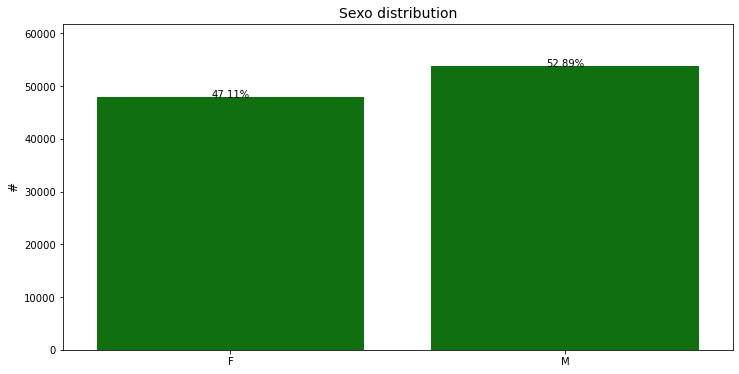

In [8]:
fa.plot_univar_cat(df, 'Sexo')

### Asignación de Roles


#### Target
Vamos a usar BAD_90_12 como target.

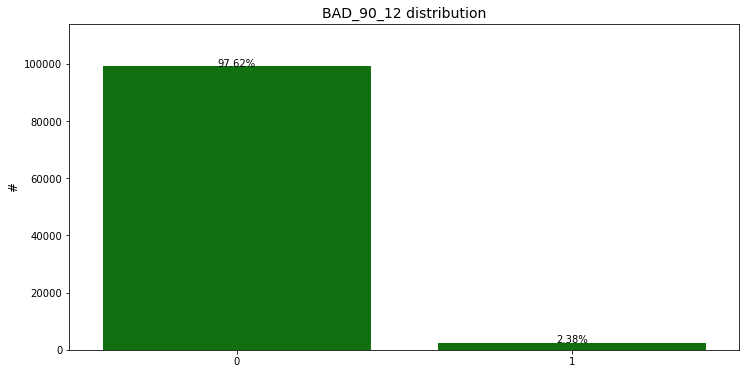

In [9]:
fa.plot_univar_cat(df, 'BAD_90_12')

BAD_90_12 = 1 corresponde a la marca de Malo. Observamos desbalance.  
Vamos a corregirlo en el entrenamiento submuestreando la clase mayoritaria.   
Veamos ahora como se clasifican el resto de las variables en continuas, discretas o categóricas.  
En este ejemplo establecemos que las variables continuas son aquellas con más de 10 valores únicos y las discretas son aquellas numéricas con menos de 10 valores únicos. Por último las categóricas son todas las no numéricas. 

In [10]:
# Listas por tipos de variables
# numerical: discrete
discrete = [
    var for var in df.columns if df[var].dtype != 'O' and var != 'BAD_90_12'
    and df[var].nunique() < 10
]

# numerical: continuous
continuous = [
    var for var in df.columns
    if df[var].dtype != 'O' and var != 'BAD_90_12' and var not in discrete
]

# categorical
categorical = [var for var in df.columns if df[var].dtype == 'O']


#### Variables discretas

In [11]:
print('Variables discretas')
pd.DataFrame({'Variable': discrete}).pipe(display)

Variables discretas


Variable
0                    IDPER
1                 BAD_90_6
2                 BAD_60_6
3                 BAD_30_3
4                Fecha_Key
..                     ...
528  Flag_Producto_Credito
529   Flag_Producto_Pasivo
530          Flag_Producto
531        Flag_Cred_o_cah
532      Flag_Monoproducto

[533 rows x 1 columns]

#### Variables continuas

In [12]:
print('Variables continuas')
pd.DataFrame({'Variable': continuous}).pipe(display)

Variables continuas


Variable
0                CLIENTE_KEY
1             Codigo_Cliente
2           Antiguedad_Banco
3                       Edad
4             Cant_Activo_PF
..                       ...
494          JUBILADO_Maxima
495           PUBLICO_Maxima
496           PRIVADO_Maxima
497  max_relacion_Sdo_Lim_CC
498               Cross_Sell

[499 rows x 1 columns]

#### Variables categóricas

In [13]:
print('Variables categóricas')
pd.DataFrame({'Variable': categorical}).pipe(display)

Variables categóricas


Variable
0                      Sexo
1         Min_Fecha_Alta_PP
2         Max_Fecha_Alta_PP
3         Min_Fecha_Baja_PP
4         Max_Fecha_Baja_PP
5         Min_Fecha_Alta_PR
6         Max_Fecha_Alta_PR
7         Min_Fecha_Baja_PR
8         Max_Fecha_Baja_PR
9         Min_Fecha_Alta_PH
10        Max_Fecha_Alta_PH
11        Min_Fecha_Baja_PH
12        Max_Fecha_Baja_PH
13     Min_Fecha_Alta_OPMOS
14     Max_Fecha_Alta_OPMOS
15     Min_Fecha_Baja_OPMOS
16     Max_Fecha_Baja_OPMOS
17  Min_Fecha_Alta_REFIPMOS
18  Max_Fecha_Alta_REFIPMOS
19  Min_Fecha_Baja_REFIPMOS
20  Max_Fecha_Baja_REFIPMOS

In [14]:
fechas = categorical
fechas.remove('Sexo')
print('Variables identificadas de Fecha')
pd.DataFrame({'Variable': fechas}).pipe(display)

Variables identificadas de Fecha


Variable
0         Min_Fecha_Alta_PP
1         Max_Fecha_Alta_PP
2         Min_Fecha_Baja_PP
3         Max_Fecha_Baja_PP
4         Min_Fecha_Alta_PR
5         Max_Fecha_Alta_PR
6         Min_Fecha_Baja_PR
7         Max_Fecha_Baja_PR
8         Min_Fecha_Alta_PH
9         Max_Fecha_Alta_PH
10        Min_Fecha_Baja_PH
11        Max_Fecha_Baja_PH
12     Min_Fecha_Alta_OPMOS
13     Max_Fecha_Alta_OPMOS
14     Min_Fecha_Baja_OPMOS
15     Max_Fecha_Baja_OPMOS
16  Min_Fecha_Alta_REFIPMOS
17  Max_Fecha_Alta_REFIPMOS
18  Min_Fecha_Baja_REFIPMOS
19  Max_Fecha_Baja_REFIPMOS

### Partición en Entrenamiento y Prueba

Para prevenir la fuga de datos ("data leakage") partimos un 70% de la muestra para entrenamiento y el resto para prueba.  Luego continuamos la exploración sólo usando los datos de entrenamiento. 
Primero mostramos la forma estándar de la industria de partición entre entrenamiento y prueba al azar.

In [15]:
# separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('BAD_90_12', axis=1),  # predictors
    df['BAD_90_12'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=101)  # seed to ensure reproducibility

print("Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)")
print(X_train.shape, X_test.shape)

Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)
(71138, 1053) (30488, 1053)


En la siguiente celda reducimos la relación entre buenos y malos a 3 a 1 en el conjunto de entrenamiento.

In [16]:
rus = RandomUnderSampler(random_state=101, sampling_strategy=1/3)
X_train_sub, y_train_sub = rus.fit_resample(X_train, y_train)

In [17]:
print("Tamaños y cantidad de variables de submuestra de Entrenamiento ")
print(X_train_sub.shape)

Tamaños y cantidad de variables de submuestra de Entrenamiento 
(6708, 1053)


In [18]:
y_train_sub.value_counts()

0    5031
1    1677
Name: BAD_90_12, dtype: int64

### Análisis bivariados  

Exploramos la distribución de las predictoras según el target con la función `desc_cols_by_target(df, cols, target)`. Con ella podemos resumir la información de un grupo grande de columnas. Podemos así detectar gruesas diferencias según los valores de target y también evaluar la presencia de nulos. 


#### Discrete

In [19]:
fa.desc_cols_by_target(X_train, discrete, y_train)

#### Continuas

In [20]:
fa.desc_cols_by_target(X_train, continuous, y_train)

#### Categóricas

In [21]:
fa.desc_cols_by_target(X_train, categorical, y_train)

#### Gráficos bivariados para continuas

Para analizar en detalle la relación entre una variable continua y el target podemos usar la función `plot_bivar_cont(df, target, cols=None, vis_col=2, target_lbl = 'target', nbins=10, discr_round=3)`.  
Esta función por defecto redondea a 3 dígitos decimales, parte en 10 bines y grafica en 2 columnas de visualización.

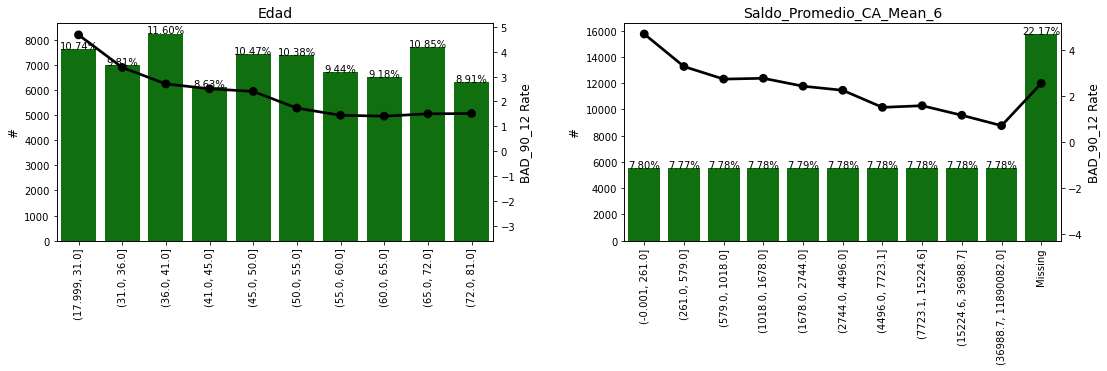

In [22]:
X_train.pipe(fa.plot_bivar_cont, target = y_train, cols = ['Edad', 'Saldo_Promedio_CA_Mean_6'], target_lbl = 'BAD_90_12', discr_round=0)

#### Gráficos bivariados para categóricas

Podemos estudiar en detalle la distribución de una variable categórica según el target con la función `plot_bivar_cat(df, target, cols=None, vis_col=2, target_lbl = 'target', max_n_vals=20, discr_round=3)`.

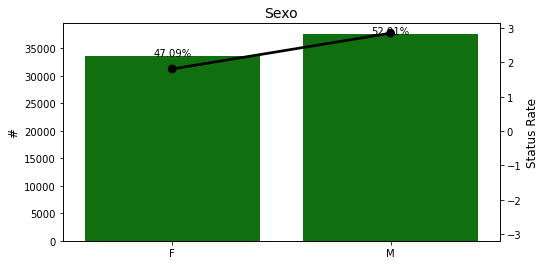

In [23]:
X_train.pipe(fa.plot_bivar_cat, target = y_train, cols = ['Sexo'], target_lbl = 'Status')

### Identificación de variables no predictoras  

A partir de los análsis hechos actualizamos los conjuntos de variables eliminando las variables que identificamos como no predictoras o problemáticas.   
Como tenemos un sólo período, no podremos usar el paso de quitar variables inestables en el tiempo como hicimos en el cuaderno original.  Por eso anulamos la variable 'no_pred_psi'.

In [24]:
# Eliminación de variables problemáticas
no_pred = ['CLIENTE_KEY', 'IDPER', 'BAD_90_6', 'BAD_60_6', 'BAD_30_3', 'Fecha_Key', 'Codigo_Cliente']
#no_pred_psi = 'month'
no_pred_psi = ''
problematicas = fechas
continuous = [i for i in continuous if i not in (problematicas + no_pred + [no_pred_psi])]  
discrete = [i for i in discrete if i not in (problematicas + no_pred + [no_pred_psi])]  
categorical = [i for i in categorical if i not in (problematicas + no_pred + [no_pred_psi])]  

## 2. ML Pipelines

Con los roles ya definidos vamos ahora a construir Pipelines de scikit-learn: https://scikit-learn.org/stable/modules/compose.html para implementar en dos pasos el desarrollo del modelo logístico.  

Para la transformación de variables usaremos la excelente librería "Feature Engine"  
https://feature-engine.readthedocs.io/en/latest/index.html

En el primer paso eliminaremos variables con criterios básicos y luego en el segundo paso procederemos a una transformación de variables y selección más sofisticadas para terminar con el ajuste del modelo logístico.   
Como se observó, desactivamos los pasos de quitar variables inestables por contar con un sólo período (201801). 


### Pipeline de Selección básica

En este pipeline eliminamos las variables casi constantes y las identificadas como problemáticas.

In [25]:

# Eliminación de problemáticas
quitar_probl = sel.DropFeatures(features_to_drop = problematicas + no_pred)
#quitar_var_psi = sel.DropFeatures(features_to_drop = no_pred_psi)

# Convertimos las discretas numéricas a string para proceso posterior. 
disc_disc = wrap.SklearnTransformerWrapper(transformer = FunctionTransformer(func = lambda x: x.astype(str)), 
                                           variables = discrete)

# Imputación de nulos de continuas para proceso posterior
cont_imp = imput.MeanMedianImputer(imputation_method = 'mean', variables=continuous)

# Imputación de nulos de las variables categóricas y discretas para proceso posterior
cat_imp = imput.CategoricalImputer(imputation_method='missing', fill_value='Nulo', return_object=True, 
                                   variables = categorical + discrete)

# Asignamos un WoE de cero a las muy poco frecuentes
cat_ralas = enc.RareLabelEncoder(tol=0.025, n_categories=1, max_n_categories=10, replace_with=0, 
                                 ignore_format = True)

# Eliminación de quasi constantes (con hasta el 97.5 de las observaciones con un único valor).
quitar_const = sel.DropConstantFeatures(tol=0.975, missing_values='include')


# pipeline de selección
sel_pipe = Pipeline(steps=[
    ('QuitarProblem', quitar_probl),    
    ('ConvStr', disc_disc),  
    ('ImputarMedias', cont_imp),
    ('ImputarCateg', cat_imp),    
    ('AgrupRaras', cat_ralas),            
    ('SelnoQuasiConst', quitar_const),                
    ])

In [26]:
sel_pipe.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('QuitarProblem',
                 DropFeatures(features_to_drop=['Min_Fecha_Alta_PP',
                                                'Max_Fecha_Alta_PP',
                                                'Min_Fecha_Baja_PP',
                                                'Max_Fecha_Baja_PP',
                                                'Min_Fecha_Alta_PR',
                                                'Max_Fecha_Alta_PR',
                                                'Min_Fecha_Baja_PR',
                                                'Max_Fecha_Baja_PR',
                                                'Min_Fecha_Alta_PH',
                                                'Max_Fecha_Alta_PH',
                                                'Min_Fecha_Baja_PH',
                                                'Max_Fecha_Baja_PH',
                                                'Min_Fecha_Alta_OPMOS',
                                                'Max_Fecha_Alta_OP

In [27]:
X_train_t1 = sel_pipe.transform(X_train_sub)
X_train_t1.shape

(6708, 666)

Con este simple paso redujimos las variables de 1053 a 666.  
En la siguiente celda actualizamos nuestro conocimiento de grupo de variables. 

In [28]:
continuous = [i for i in continuous if i in X_train_t1.columns]  
discrete = [i for i in discrete if i in X_train_t1.columns]  
categorical = [i for i in categorical if i in X_train_t1.columns]  

#### Exploración de selección de variables

Podemos ver las variables eliminadas en cada paso de seleccíón de variables invoncando al atributo `features_to_drop_`. 

In [29]:
sel_pipe['SelnoQuasiConst'].features_to_drop_

['Fecha_Depuracion_Cobis',
 'Banco_Key',
 'Banca_Key',
 'Empleado',
 'Cant_Inmovilizado_PF',
 'Cant_Dolar_PF',
 'Saldo_Dia_Pesos_PF',
 'Saldo_Promedio_Pesos_PF',
 'Saldo_Dia_Dolar_PF',
 'Saldo_Promedio_Dolar_PF',
 'Saldo_Dia_Total_PF',
 'Saldo_Promedio_Total_PF',
 'Flag_Impago_Seg',
 'Dias_Atraso_Seg',
 'Cant_AP._Seg',
 'Cant_ATM_Seg',
 'Cant_ATM_PLUS_Seg',
 'Cant_MP_Seg',
 'Cant_Prot_VP_Seg',
 'Saldo_Dia_MAC',
 'Saldo_Promedio_MAC',
 'Saldo_Promedio_Acreedor_MAC',
 'Saldo_Promedio_Deudor_MAC',
 'Cantidad_Cuentas_MAC',
 'Cantidad_Debitos_MAC',
 'Cantidad_Movimientos_MAC',
 'Limite_Acuerdo_MAC',
 'Dias_Continuos_Saldo_Deudor_MAC',
 'Dias_Descubierto_Con_Acuerdo_MAC',
 'Dias_Exceso_Acuerdo_MAC',
 'Flag_MAC',
 'Flag_Acuerdo_MAC',
 'Porc_Sdo_prom_Lim_MAC',
 'Flag_Dias_Atraso_30_MAC',
 'Flag_Dias_Atraso_60_MAC',
 'Flag_Dias_Atraso_90_MAC',
 'Flag_Dias_Desc_30_MAC',
 'Flag_Dias_Desc_60_MAC',
 'Flag_Dias_Desc_90_MAC',
 'Flag_Porc_Sdo_prom_Lim_25_MAC',
 'Flag_Porc_Sdo_prom_Lim_50_MAC',
 'Flag_

### Pipeline de Modelado

Los pasos que construimos son:
1) Agrupación de variables 
2) Transformación por WoE 
3) Seleccionamos variables por 7 criterios usando parámetros estándares.
4) Entrenamos una regresión logística

In [30]:

# 1) Agrupación de variables.
# Discretización de continuas 
cont_disc = disc.EqualFrequencyDiscretiser(q=10, variables=continuous, return_object=True) # importante: retornar como categórica

# 2) Transformación por WoE
woe = fa.WoEEncoderZeroTreat()

# Asignamos un WoE de cero a las muy poco frecuentes ó a las no conocidas durante el entrenamiento
woe_imp = imput.ArbitraryNumberImputer(arbitrary_number=0)

cat_ralas = enc.RareLabelEncoder(tol=0.025, n_categories=1, max_n_categories=10, replace_with=0, 
                                 ignore_format = True)

# Restauramos el formato numérico de los WoE
cat_2_num = wrap.SklearnTransformerWrapper(transformer = FunctionTransformer(func = lambda x: x.astype(float)))

# 3) Eliminamos variables cuasi constantes y con PSI alto

# Eliminación de quasi constantes (con hasta el 97.5 de las observaciones con un único valor).
quitar_const = sel.DropConstantFeatures(tol=0.975, missing_values='include')

# Seleccionamos variables con Population Stability Index, PSI < 0.25 
# quitar_inest = sel.DropHighPSIFeatures(split_col='month', cut_off=5, threshold = 0.25)

# Seleccionamos variables con Índice de Gini > 0.01
quitar_bajo_roc = sel.SelectBySingleFeaturePerformance(estimator=LogisticRegression(random_state=11), 
                                                       scoring="roc_auc", cv=3, threshold=fa.gini_2_auc(0.01))

# Seleccionamos variables correlacionadas de forma "inteligente"
# De cada grupo de variables correlacionadas con coef. de pearson > 0.95 entre sí, elegimos la de mejor performance. 
quitar_correlac = sel.SmartCorrelatedSelection(threshold=0.95, missing_values='raise', 
                                               selection_method='model_performance', 
                                               estimator=LogisticRegression(random_state=101), scoring='roc_auc', cv=3)

# Seleccionamos variables por Lasso, i.e. las que resultan con coeficiente menor a 0.01 en este método
sel_x_Lasso = wrap.SklearnTransformerWrapper(transformer = SelectFromModel(
    LogisticRegression(penalty = "l1", C = 0.1, solver = 'saga', random_state = 102), threshold = 0.01))

# Seleccionamos variables por Random Forest, i.e., las que tienen más de 0.01 de importancia. 
sel_x_RF = wrap.SklearnTransformerWrapper(transformer = SelectFromModel(
    RandomForestClassifier(min_samples_leaf = 100, random_state = 103), threshold = 0.01))
                                               
# Selección Forward Stepwise. Seleccionamos variables que en cada paso mejoran el índice Roc-auc en 0.01. 
sel_x_Logistic_Fwd = sel.RecursiveFeatureAddition(estimator=LogisticRegression(random_state=104), threshold=0.01)

# Regresión Logística con parámetros por defecto de sci-kit learn.
reg_log = LogisticRegression(random_state=105)

# pipeline
model_pipe = Pipeline(steps=[
    ('DiscXDeciles', cont_disc),
    ('CodifWoE', woe),
    ('CatDesc', woe_imp),
    ('AgrupRaras', cat_ralas),            
    ('ANum', cat_2_num), 
    ('SelnoQuasiConst', quitar_const),    
#    ('SelxEstab', quitar_inest),     
#    ('QuitarPSIVar', quitar_var_psi), 
    ('SelxROC', quitar_bajo_roc),
    ('SelnoCorr', quitar_correlac),
    ('SelxLasso', sel_x_Lasso),
    ('SelxRF', sel_x_RF),
    ('SelFwd', sel_x_Logistic_Fwd),
    ('logit', reg_log)
    ])

### Construcción del modelo ALL

Primero aplicamos el pipeline sobre todo el conjunto de entrenamiento para desarrollar el primer modelo, que llamamos ALL.

In [31]:
model_pipe.fit(X_train_t1, y_train_sub)

Pipeline(steps=[('DiscXDeciles',
                 EqualFrequencyDiscretiser(return_object=True,
                                           variables=['Antiguedad_Banco',
                                                      'Edad', 'Cant_Activo_PF',
                                                      'Cant_Pesos_PF',
                                                      'Cant_Activa_CA',
                                                      'Saldo_Promedio_CA',
                                                      'Cantidad_CA',
                                                      'Saldo_Promedio_CA_Mean_12',
                                                      'Saldo_Promedio_CA_Mean_3',
                                                      'Saldo_Promedio_CA_Mean_6',
                                                      'Saldo_Dia_CC',
                                                      'Saldo_Promedio_CC',
                                                      'Saldo_Promedio_A

### Exploración de transformaciones

Veamos como quedó el conjunto de entrenamiento transformado por el pipeline justo antes del último paso que realiza el ajuste del modelo logístico.

In [32]:
X_train_t2 = model_pipe[:-1].transform(X_train_t1)
X_train_t2.head()

Max_Plazo_Original_PP  Flag_Porc_Sdo_Limite_25_TC_Sum_3  \
0                  -0.26                             -0.43   
1                  -0.26                             -0.43   
2                  -0.26                              0.87   
3                  -0.26                             -0.43   
4                  -0.26                             -0.43   

   Flag_Situacion_Banco_1_Sum_12  Ant_Dias_Mora_menor_30_Min_12  \
0                          -0.24                          -0.48   
1                           0.41                          -0.48   
2                           0.41                          -0.48   
3                          -0.24                          -0.48   
4                          -0.24                          -0.48   

   PRIVADO_Cantidad  SITUACION_CENDEU_3  
0              0.32               -0.19  
1              0.32               -0.19  
2              0.32               -0.19  
3              0.32               -0.19  
4              0.09               -0.19

Comprobamos que el modelo logístico se aplica a las variables transformadas por WoE.  
Veamos en detalle dos variables, antes y después de las transformaciones.

### Exploración de selección de variables

Podemos ver las variables eliminadas en cada paso de seleccíón de variables invoncando al atributo `features_to_drop_`. 

In [33]:
model_pipe['SelnoQuasiConst'].features_to_drop_

['Edad',
 'Cant_Activo_PF',
 'Cant_Pesos_PF',
 'Saldo_Promedio_CA',
 'Saldo_Promedio_CA_Mean_12',
 'Saldo_Promedio_CA_Mean_3',
 'Saldo_Promedio_CA_Mean_6',
 'Saldo_Dia_CC',
 'Saldo_Promedio_CC',
 'Saldo_Promedio_Acreedor_CC',
 'Saldo_Promedio_Deudor_CC',
 'Limite_Acuerdo_CC',
 'Dias_Descubierto_Con_Acuerdo_CC',
 'Dias_Exceso_Acuerdo_CC',
 'Saldo_Promedio_CC_Mean_12',
 'Saldo_Promedio_Acreedor_CC_Mean_12',
 'Saldo_Promedio_Deudor_CC_Mean_12',
 'Limite_Acuerdo_CC_Mean_12',
 'Dias_Descubierto_Con_Acuerdo_CC_Max_12',
 'Flag_Dias_Desc_30_CC_Sum_12',
 'Flag_Dias_Desc_60_CC_Sum_12',
 'Flag_Dias_Desc_90_CC_Sum_12',
 'Saldo_Promedio_CC_Mean_3',
 'Saldo_Promedio_Acreedor_CC_Mean_3',
 'Saldo_Promedio_Deudor_CC_Mean_3',
 'Limite_Acuerdo_CC_Mean_3',
 'Dias_Continuos_Saldo_Deudor_CC_Max_3',
 'Dias_Descubierto_Con_Acuerdo_CC_Max_3',
 'Dias_Exceso_Acuerdo_CC_Max_3',
 'Saldo_Promedio_CC_Mean_6',
 'Saldo_Promedio_Acreedor_CC_Mean_6',
 'Saldo_Promedio_Deudor_CC_Mean_6',
 'Limite_Acuerdo_CC_Mean_6',
 'Dia

In [34]:
model_pipe['SelxROC'].features_to_drop_

['Cant_Paquetes',
 'Cant_Seg',
 'Cant_Inmovilizada_CA',
 'Cantidad_Cuentas_CC',
 'Cantidad_Debitos_CC',
 'Cantidad_Movimientos_CC',
 'Flag_CC',
 'Flag_Dias_Atraso_30_CC',
 'Flag_Dias_Atraso_60_CC',
 'Flag_Dias_Atraso_90_CC',
 'Flag_Dias_Desc_30_CC',
 'Flag_Dias_Desc_60_CC',
 'Flag_Dias_Desc_90_CC',
 'Dias_Continuos_Saldo_Deudor_CC_Max_12',
 'Dias_Exceso_Acuerdo_CC_Max_12',
 'Flag_Dias_Atraso_90_CC_Sum_12',
 'Ant_Atraso_90_CC_Min_12',
 'Flag_Dias_Atraso_60_CC_Sum_3',
 'Flag_Dias_Atraso_90_CC_Sum_3',
 'Flag_Dias_Desc_30_CC_Sum_3',
 'Flag_Dias_Desc_60_CC_Sum_3',
 'Flag_Dias_Desc_90_CC_Sum_3',
 'Ant_Atraso_60_CC_Min_3',
 'Ant_Atraso_90_CC_Min_3',
 'Dias_Continuos_Saldo_Deudor_CC_Max_6',
 'Dias_Exceso_Acuerdo_CC_Max_6',
 'Flag_Dias_Atraso_90_CC_Sum_6',
 'Flag_Dias_Desc_60_CC_Sum_6',
 'Flag_Dias_Desc_90_CC_Sum_6',
 'Ant_Atraso_90_CC_Min_6',
 'Limite_Master_TC',
 'Seguros_TC',
 'Limite_Master_TC_Mean_12',
 'Limite_Master_TC_Mean_3',
 'Limite_Master_TC_Mean_6',
 'Flag_Seguros',
 'Flag_Paquete'

In [35]:
model_pipe['SelnoCorr'].features_to_drop_

['Cant_Activa_CA',
 'Flag_Acuerdo_CC',
 'Flag_Acuerdo_Sum_12',
 'Flag_Porc_Sdo_prom_Lim_90_CC_Sum_12',
 'Ant_Atraso_60_CC_Min_12',
 'Flag_Dias_Atraso_30_CC_Sum_3',
 'Flag_Porc_Sdo_prom_Lim_90_CC_Sum_3',
 'Flag_Acuerdo_Sum_6',
 'Flag_Porc_Sdo_prom_Lim_90_CC_Sum_6',
 'Ant_Atraso_30_CC_Min_6',
 'Ant_Atraso_60_CC_Min_6',
 'Tend_Limite_Acuerdo_CC_1_3',
 'Tend_Limite_Acuerdo_CC_1_6',
 'Tend_Limite_Acuerdo_CC_3_6',
 'Tend_Limite_Acuerdo_CC_6_12',
 'Cant_PP_Max_3',
 'Flag_Dias_Atraso_30_PP_Sum_3',
 'Flag_Dias_Atraso_60_PP_Sum_3',
 'Flag_Dias_Atraso_90_PP_Sum_3',
 'Ant_flag_PP_Min_3',
 'Ant_Atraso_30_PP_Min_3',
 'Ant_Atraso_60_PP_Min_3',
 'Ant_Atraso_90_PP_Min_3',
 'Flag_Dias_Atraso_30_PP_Sum_6',
 'Flag_Dias_Atraso_60_PP_Sum_6',
 'Flag_Dias_Atraso_90_PP_Sum_6',
 'Ant_flag_PP_Min_6',
 'Ant_Atraso_30_PP_Min_6',
 'Ant_Atraso_60_PP_Min_6',
 'Ant_Atraso_90_PP_Min_6',
 'Ant_Atraso_30_PP_Min_12',
 'Ant_Atraso_60_PP_Min_12',
 'Ant_Atraso_90_PP_Min_12',
 'Cant_PP',
 'Flag_PP',
 'Flag_Dias_Atraso_30_PP',

In [36]:
model_pipe['SelxLasso'].features_to_drop_

['Antiguedad_Banco',
 'Cant_HOGAR_Seg',
 'Cantidad_CA',
 'Dias_Continuos_Saldo_Deudor_CC',
 'Porc_Sdo_prom_Lim_CC',
 'Flag_Porc_Sdo_prom_Lim_25_CC',
 'Flag_Porc_Sdo_prom_Lim_50_CC',
 'Flag_Porc_Sdo_prom_Lim_75_CC',
 'Flag_Porc_Sdo_prom_Lim_90_CC',
 'Flag_CC_Sum_12',
 'Porc_Sdo_prom_Lim_CC_Mean_12',
 'Flag_Dias_Atraso_30_CC_Sum_12',
 'Flag_Dias_Atraso_60_CC_Sum_12',
 'Flag_Porc_Sdo_prom_Lim_25_CC_Sum_12',
 'Flag_Porc_Sdo_prom_Lim_50_CC_Sum_12',
 'Flag_Porc_Sdo_prom_Lim_75_CC_Sum_12',
 'Ant_Atraso_30_CC_Min_12',
 'Flag_CC_Sum_3',
 'Porc_Sdo_prom_Lim_CC_Mean_3',
 'Flag_Porc_Sdo_prom_Lim_25_CC_Sum_3',
 'Flag_Porc_Sdo_prom_Lim_50_CC_Sum_3',
 'Ant_Atraso_30_CC_Min_3',
 'Flag_CC_Sum_6',
 'Porc_Sdo_prom_Lim_CC_Mean_6',
 'Flag_Dias_Atraso_30_CC_Sum_6',
 'Flag_Dias_Atraso_60_CC_Sum_6',
 'Flag_Dias_Desc_30_CC_Sum_6',
 'Flag_Porc_Sdo_prom_Lim_25_CC_Sum_6',
 'Flag_Porc_Sdo_prom_Lim_50_CC_Sum_6',
 'Flag_Porc_Sdo_prom_Lim_75_CC_Sum_6',
 'Tend_sdo_prom_Lim_CC_1_3',
 'Tend_sdo_prom_Lim_CC_3_6',
 'Tend_

In [37]:
model_pipe['SelxRF'].features_to_drop_

['Sexo',
 'Cant_dolares_CA',
 'Flag_Acuerdo_Sum_3',
 'Flag_Porc_Sdo_prom_Lim_75_CC_Sum_3',
 'Flag_PP_Sum_6',
 'Cuentas_Hab_TC',
 'Cuentas_Hab_Visa_TC',
 'Limite_Visa_TC',
 'Cantidad_Pagos_TC',
 'Con_Resumen_Master_TC',
 'Flag_Porc_Pagos_Saldo_25_TC',
 'Flag_Porc_Sdo_Limite_25_TC_Sum_12',
 'Flag_Revolving_25_TC_Sum_12',
 'Flag_Revolving_50_TC_Sum_12',
 'Flag_Revolving_90_TC_Sum_12',
 'Flag_Porc_Pagos_Saldo_90_TC_Sum_12',
 'Flag_Porc_Pagos_Saldo_100_TC_Sum_12',
 'Limite_Visa_TC_Mean_3',
 'Flag_Revolving_75_TC_Sum_3',
 'Flag_Cuentas_Con_Problemas_TC_Sum_6',
 'Flag_Adelantos_TC_Sum_6',
 'Flag_Porc_Sdo_Limite_90_TC_Sum_6',
 'Flag_Revolving_75_TC_Sum_6',
 'Ant_Consumos_TC_Min_6',
 'Tend_Porc_Sdo_Limite_6_12_TC',
 'Tend_Porc_Revolving_3_6_TC',
 'Flag_Situacion_Banco_2_Sum_6',
 'Flag_Situacion_Banco_1_Sum_3',
 'Flag_Situacion_Mayor_1_Sum_3',
 'Flag_Acuerdo',
 'Flag_Plazo_Fijo']

In [38]:
model_pipe['SelFwd'].features_to_drop_

['Flag_PP_Sum_3',
 'Cant_PP_Max_12',
 'Flag_Saldo_Financiado_TC',
 'Flag_Porc_Sdo_Limite_25_TC',
 'Flag_Revolving_25_TC',
 'Flag_Porc_Pagos_Saldo_50_TC_Sum_12',
 'Flag_Revolving_25_TC_Sum_3',
 'Flag_Estado_Normal_TC_Sum_6',
 'Flag_Revolving_25_TC_Sum_6',
 'Flag_Porc_Pagos_Saldo_50_TC_Sum_6',
 'Flag_Porc_Pagos_Saldo_90_TC_Sum_6',
 'Flag_Situacion_Banco_1_Sum_6',
 'Flag_Dias_Mora_menor_30_Sum_6',
 'Ant_Dias_Mora_menor_30_Min_6',
 'Situacion_Banco_Max_12',
 'Flag_Dias_Mora_menor_30_Sum_12',
 'Pension_Graciable_Flag',
 'PUBLICO_M_Cantidad',
 'PRIVADO_B_Cantidad',
 'JUBILADO_Cantidad']

Si hubieran variables eliminadas en el paso "SelxEstab" podríamos graficarlas con la función `plot_unstables()`.  
Para el resto de los pasos de Selección de variables podemos visualizar la importancia de cada variable y su ubicación en relación al punto de corte elegido con la función `plot_importance()`.  
Cuando hay muchas variables conviene ajustar el parámetro xlims para no mostrar las variables con importancia fuera de este rango. 

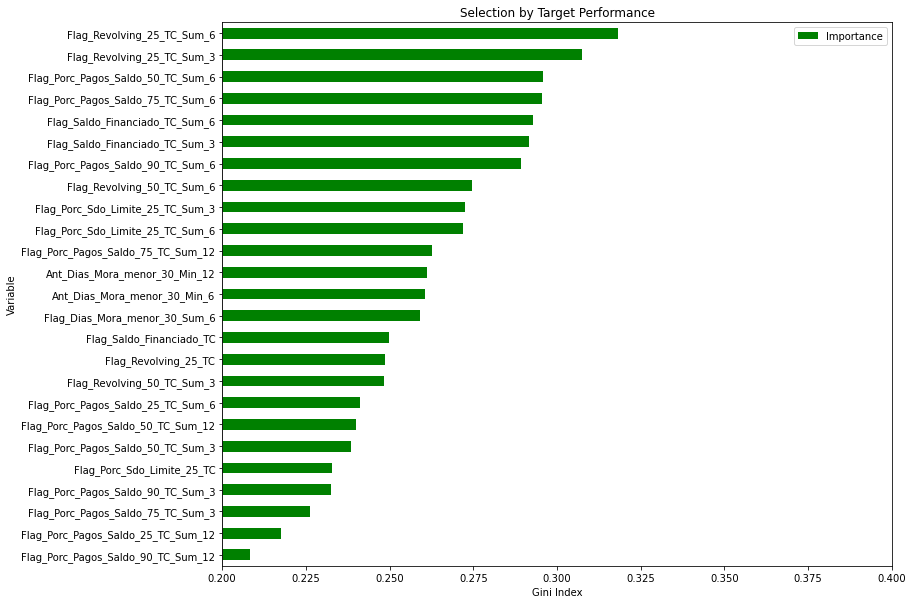

In [39]:
fa.plot_importance(model_pipe['SelxROC'], cutoff = 0.20, xlims = [0.20, 0.4], title = "Selection by Target Performance", 
                    xlabel = 'Gini Index' , scale_transf = fa.auc_2_gini)

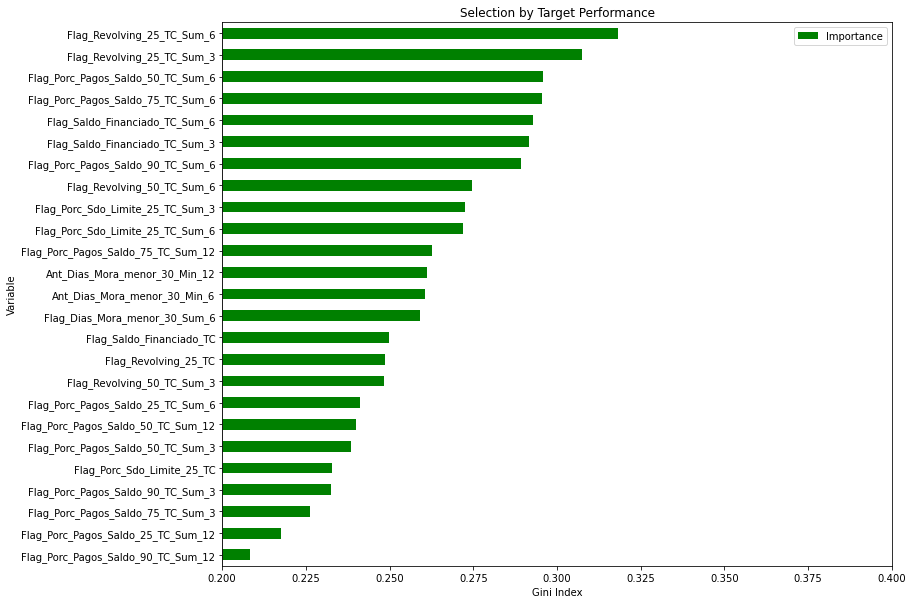

In [40]:
fa.plot_importance(model_pipe['SelxROC'], cutoff = 0.2, xlims = [0.2, 0.4], title = "Selection by Target Performance", 
                    xlabel = 'Gini Index' , scale_transf = fa.auc_2_gini)

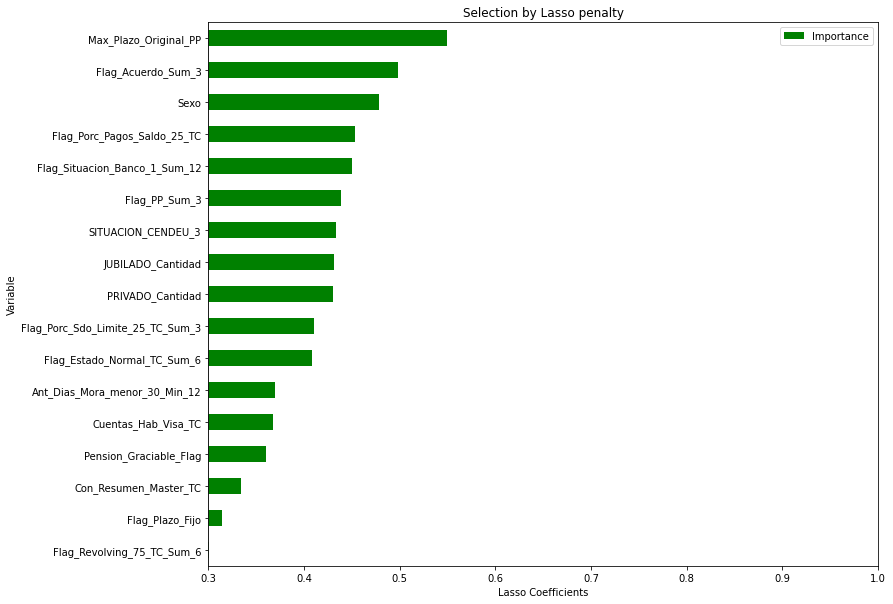

In [41]:
fa.plot_importance(model_pipe['SelxLasso'], cutoff = 0.3, xlims = [0.3, 1], title = "Selection by Lasso penalty", 
                    xlabel = 'Lasso Coefficients')

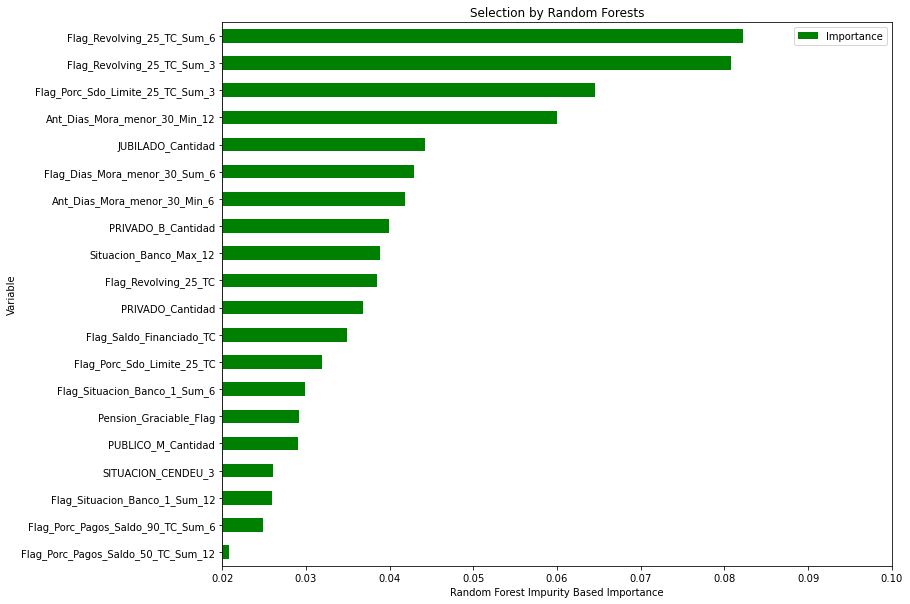

In [42]:
fa.plot_importance(model_pipe['SelxRF'], cutoff = 0.02, xlims = [0.02, 0.1], 
    title = "Selection by Random Forests", xlabel = 'Random Forest Impurity Based Importance')

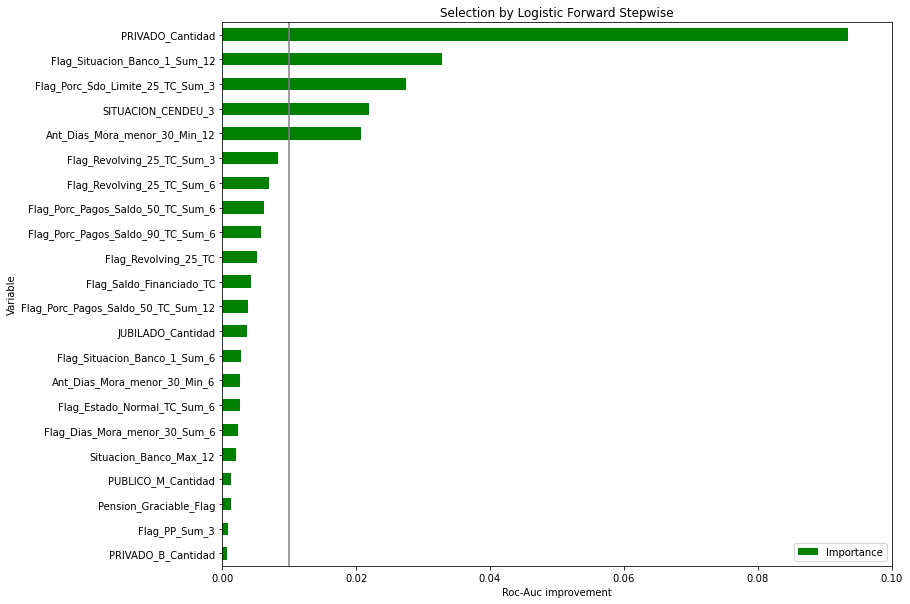

In [43]:
fa.plot_importance(model_pipe['SelFwd'], cutoff = 0.01, xlims = [0, 0.1], 
                   title = "Selection by Logistic Forward Stepwise", xlabel = 'Roc-Auc improvement')

## 3. Resumen del Entrenamiento

En esta sección presentamos el resultado de la selección de variables y los coeficientes del modelo logístico.  
Recordemos que ajustamos un modelo para estimar el evento target = 1.  Si este evento significa ser "malo", a mayor score, mayor será la probabilidad de ser "malo". 

### Coeficientes del modelo

Al estar codificadas por WoE los coeficientes están relacionados con la importancia de la variable dentro del modelo. 
Usamos la función `model_coef(model_pipeline, title)` para graficarlos.   

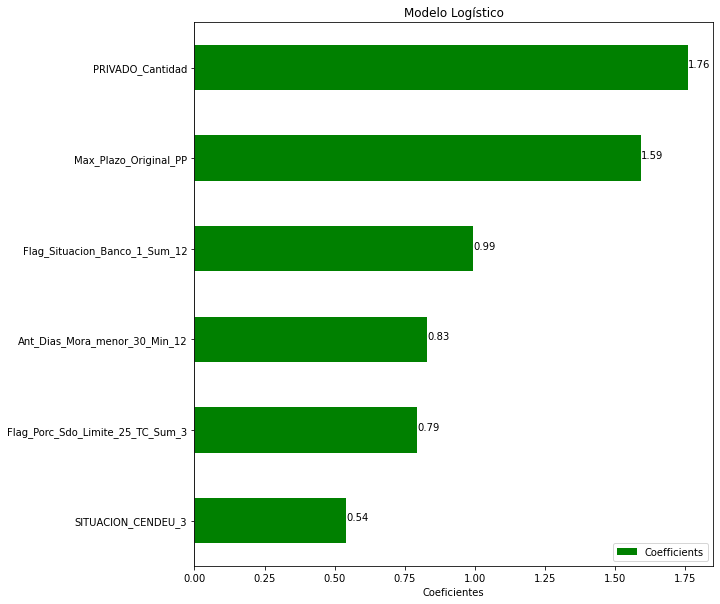

In [44]:
fa.model_coef(model_pipe, "Modelo Logístico")

## 4. Persistencia del Modelo

Con el siguiente código mostramos como podemos salvar el modelo a disco. 

In [45]:
with open("Seleccion_v1_ALL.pkl", "wb") as pkl_file:
        dump(sel_pipe, pkl_file)

In [46]:
with open("Modelo_logistico_v1_ALL.pkl", "wb") as pkl_file:
        dump(model_pipe, pkl_file)

In [47]:
with open("Seleccion_v1_ALL.pkl", "rb") as pkl_file:
        sel_pipe = load(pkl_file)

In [48]:
with open("Modelo_logistico_v1_ALL.pkl", "rb") as pkl_file:
        model_pipe = load(pkl_file)

## 5. Predicciones del Modelo 

Con la función de scikit-learn `predict_proba()` obtenemos los scores (en probabilidades) resultantes de aplicar el modelo al dataset dado como argumento. 
Ref: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba

De esta manera aplicamos el modelo a los conjuntos de entrenamiento (train) y prueba (test).  
Notemos que la funcion `predict_proba()` devuelve dos columnas.  Elegimos la segunda para estimar la probabilidad de target = 1.  
También notemos que con 'del' liberamos la memoria de datasets intermedios no necesarios para las validaciones.

In [49]:
X_train_t1 = sel_pipe.transform(X_train)
y_train_score = model_pipe.predict_proba(X_train_t1)[:,1]
del X_train_t1

In [50]:
X_train_sub_t1 = sel_pipe.transform(X_train_sub)
y_train_sub_score = model_pipe.predict_proba(X_train_sub_t1)[:,1]
del X_train_sub_t1

In [51]:
X_test_t1 = sel_pipe.transform(X_test)
y_test_score = model_pipe.predict_proba(X_test_t1)[:,1]
del X_test_t1

Notar que recién en esta sección usamos los conjuntos de Prueba.

## 6. Performance del Modelo

Evaluamos aquí la performance del modelo, que llamamos ALL, por ser aplicado a toda la población.

Con la función `bsl_vs_test_report(bsl_score, bsl_target, test_score, test_target, nbins=10, score_model_name='Modelo v1')` realizamos en un paso la comparación entre dos scores que pueden surgir de dos modelos o de un mismo modelo aplicados a dos datasets.  Al primer score lo llamamos "Baseline" y al segundo "Test". 

### Submuestra de Entrenamiento vs Entrenamiento Completo

En la siguiente celda comparamos la performance del modelo aplicado en la submuestra usada en el entrenamiento con la performance del modelo aplicado a toda la muestra del entrenamiento.  Este reporte es útil para una posterior calibración que corrija el sesgo introducido por usar una submuestra. 

ALL Submuestra Train vs. Train completo  Baseline performance report


ALL Submuestra Train vs. Train completo  Testing performance report


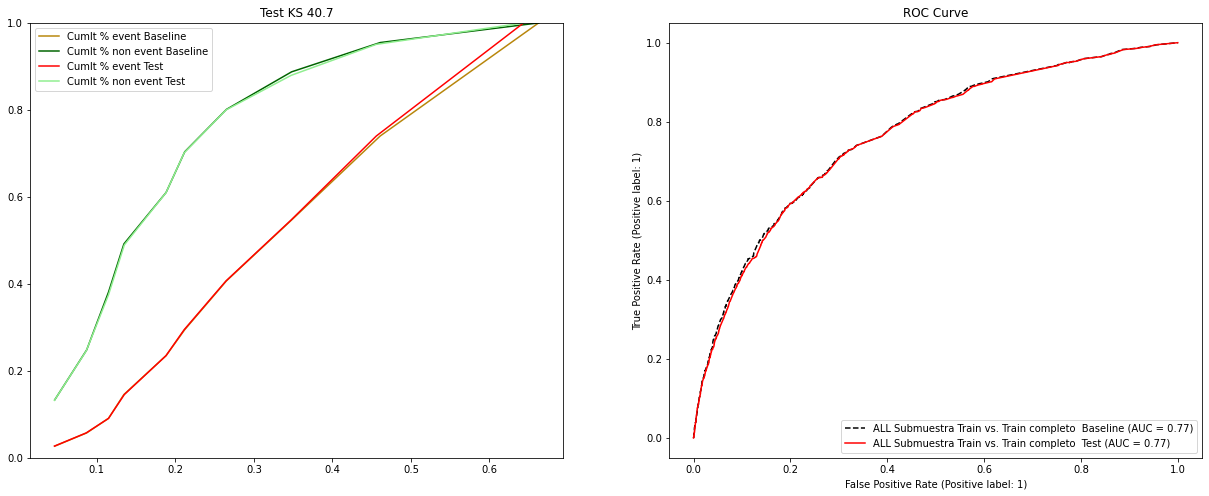

In [52]:
rep = fa.bsl_vs_test_report(bsl_score = y_train_sub_score, bsl_target = y_train_sub, 
                         test_score = y_train_score, test_target = y_train, 
                         nbins=10, score_model_name='ALL Submuestra Train vs. Train completo ')

### Entrenamiento vs Prueba

En la siguiente celda verificamos la estabilidad del modelo realizando la comparación entre los scores del modelo ALL aplicados a los datos de Entrenamiento y a los datos de la Prueba.

ALL Train vs. Test  Baseline performance report


ALL Train vs. Test  Testing performance report


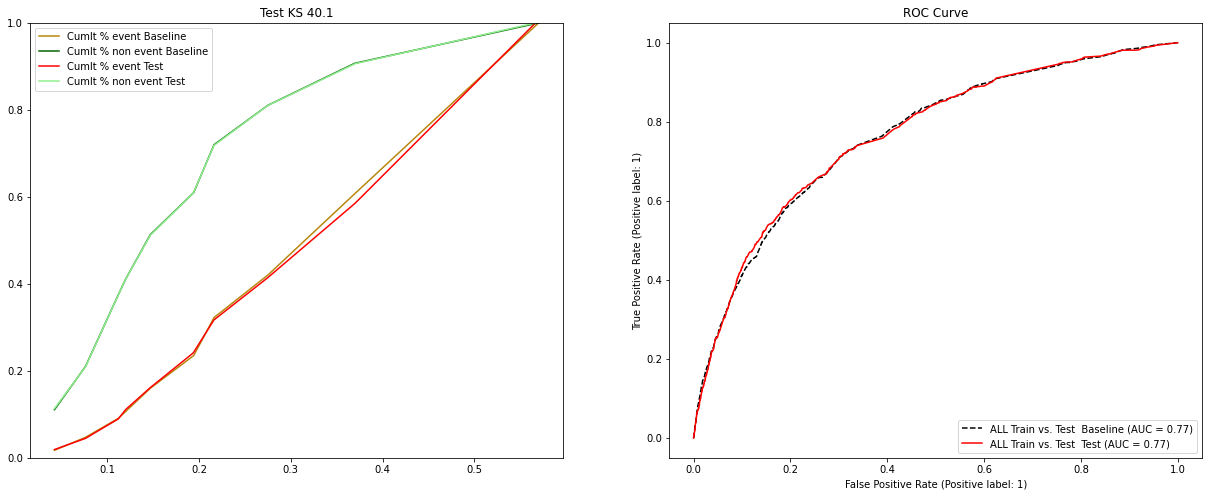

In [53]:
rep = fa.bsl_vs_test_report(bsl_score = y_train_score, bsl_target = y_train, 
                         test_score = y_test_score, test_target = y_test, 
                         nbins=10, score_model_name='ALL Train vs. Test ')

### en Segmento PP

Mostramos ahora como generar las predicciones para un segmento particular.   
Para añadir las predicciones al conjunto original usamos la función de pandas concat.
Usamos del dataset original sólo las columnas no predictoras, que incluyen las columnas identificatorias.

In [54]:
# Cómo alternativa se podría haber hecho
#y_all_score = np.concatenate((y_train_score, y_test_score))
#y_all = np.concatenate((y_train, y_test))
df_pp = df.loc[df['Flag_PP']>0]
X_pp_t1 = sel_pipe.transform(df_pp.drop('BAD_90_12', axis=1))
y_pp_score = model_pipe.predict_proba(X_pp_t1)[:,1]
y_pp = df_pp['BAD_90_12']
df_pp = df_pp[no_pred]
del X_pp_t1

In [55]:
df_pp = pd.concat([df_pp, pd.DataFrame({'BAD_90_12': y_pp, 'score': y_pp_score})], axis = 1)
df_pp.head()

CLIENTE_KEY   IDPER  BAD_90_6  BAD_60_6  BAD_30_3  Fecha_Key  \
0      1444211  201801         0         0         0        NaN   
2      5420861  201801         0         0         0        NaN   
3      7923551  201801         0         0         0        NaN   
5      1083401  201801         1         1         0        NaN   
7      8117531  201801         0         0         0        NaN   

   Codigo_Cliente  BAD_90_12  score  
0         2316694          0   0.59  
2         6751450          0   0.31  
3         8952144          0   0.29  
5         1953864          1   0.28  
7         9126489          0   0.47

Realizamos un reporte en un segmento particular.  Para los casos donde se necesita sólo el reporte de performance empleamos la función `model_report(score, target, quantiles, score_model_name)`.  

In [56]:
rep = fa.model_report(score = y_pp_score, target = y_pp, quantiles=10, 
                   score_model_name='Modelo Logistico ALL en Segmento PP')

Modelo Logistico ALL en Segmento PP performance report


## Apéndice

### Referencias librerías de ML

Scikit Learn: https://scikit-learn.org/stable/getting_started.html  
Feature Engine: https://feature-engine.readthedocs.io/en/latest/quickstart/index.html

### Referencia de funciones auxiliares

A continuación mostramos una referencia rápida de las funciones auxiliares de la librería Func_aux_v2.py. 
Notar que podemos consultar la documentación de cada función como cualquier otra función python con help(). 

#### `plot_univar_cat()`

In [57]:
help(fa.plot_univar_cat)

Help on function plot_univar_cat in module fa.Plots:

plot_univar_cat(df, col)
    Grafica en barras los valores de una columna de un DataFrame
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla que contiene la columna
    col : str
       nombre de la columna 
       
    Retorna
    _______
    None
       Muestra el gráfico
    
    Ejemplo
    _______
    import fa as fa
    fa.plot_univar_cat(df, 'Gender')



#### `plot_bivar_cat()`

In [58]:
help(fa.plot_bivar_cat)

Help on function plot_bivar_cat in module fa.Plots:

plot_bivar_cat(df, target, cols=None, vis_col=2, target_lbl='target', max_n_vals=20, discr_round=3)
    Grafica en barras y lineas lista de columnas de un DataFrame 
    
    Para cada columna de la lista dada se realiza un gráfico de barras y líneas.
    Las barras muestran los números de observaciones mientras que los puntos muestran 
    la proporción de observaciones con target = 1.
    Los gráficos se disponen en un arreglo rectangular con 
    vis_col columnas de visualización.
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas
    cols : list
       lista de nombres de columna
    vis_col : int = 2
       cantidad de columnas de visualización del gráfico múltiple.
    target_lbl : str = 'Status'
       nombre de la columna usada como target.
    max_n_vals : int = 20
       número máximo de categorías distintas para mostrar en un gráfico.
    discr_round : int = 3
       cantidad

#### `plot_bivar_cont()`

In [59]:
help(fa.plot_bivar_cont)

Help on function plot_bivar_cont in module fa.Plots:

plot_bivar_cont(df, target, cols=None, vis_col=2, target_lbl='target', nbins=10, discr_round=3)
    Grafica en barras y lineas lista de columnas de un DataFrame 
    
    Para cada columna de la lista dada se realiza un gráfico de barras y líneas.
    Las barras muestran los números de observaciones mientras que los puntos muestran 
    la proporción de observaciones con target = 1.
    Los gráficos se disponen en un arreglo rectangular con 
    vis_col columnas de visualización.
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas
    cols : list
       lista de nombres de columna
    vis_col : int = 2
       cantidad de columnas de visualización del gráfico múltiple.
    target_lbl : str = 'Status'
       nombre de la columna usada como target.
    nbins : int = 10
       número de cuantiles o bines usados para discretizar cada columna. Por defecto, 
       se parte la columna continua

#### `desc_cols_by_target()`

In [60]:
help(fa.desc_cols_by_target)

Help on function desc_cols_by_target in module fa.Reports:

desc_cols_by_target(df, cols, target)
    Describe columnas por cada nivel de target 
    
    Para cada columna de la lista dada se construye una tabla con estadísticos que resumen la distribución de la columna por cada valor de "target". 
    Para las variables numéricas se muestran la cantidad, media, desvío estándar, mínimo, cuantiles 25%, 50% y 75%, máximo y cantidad y porcentaje de nulos.
    Para las variables categóricas se muestran la cantidad, la cantidad de valores únicos, el valor más frecuente, y la cantidad y porcentaje de nulos.
     
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas a describir
    cols : list
       lista de nombres de columna
    target : pandas.Series
       vector con los valores de target. No es necesario que pertenezca a df.
       
    Retorna
    _______
    None
       Muestra las tablas con los resúmenes.
            
    Ejemplo
    _______

#### `plot_unstables()`

In [61]:
help(fa.plot_unstables)

Help on function plot_unstables in module fa.Plots:

plot_unstables(model_pipe_res, cutoff, title='Selection by Population Stability Index', xlims=[0, 1], xlabel='PSI')
    Gráfico de inestabilidad de variables del paso de Selección de variables según PSI
    
    Reporta la inestabilidad de las variables calculada según 
    feature_engine.selection.DropHighPSIFeatures()
    Ref: https://feature-engine.readthedocs.io/en/latest/api_doc/selection/DropHighPSIFeatures.html
    En general sólo se requiere un objeto con el atributo psi_values_
    
    Parámetros
    __________
    model_pipe_res : objeto de clase class feature_engine.selection.DropHighPSIFeatures()
        En general se acepta cualquier objeto con atributo psi_values_ 
        que retorne un diccionario los valores de PSI.  
        
    cutoff : double = 0.05
        posición de la línea vertical. 
    
    xlims : [double, double] = [0,1]
        Limites del eje x del gráfico. No se muestran las variables con valores fue

#### `plot_importance()`

In [62]:
help(fa.plot_importance) 

Help on function plot_importance in module fa.Plots:

plot_importance(model_pipe_res, cutoff=0.05, xlims=[0, 1], title='Selection by Importance', xlabel='Importance', scale_transf=None)
    Gráfico de importancia de variables 
    
    Grafica la importancia de las variables calculada por los pasos de Selección de Variables del Pipeline que 
    reportan los atributos feature_importance_ o feature_performance_
    Ref: https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SelectBySingleFeaturePerformance.html
    
    Parámetros
    __________
    model_pipe_res : Objeto con atributo feature_performance_ ó feature_performance_ 
        que retorne un diccionario con los nombres de variable como claves.  
        
    cutoff : double = 0.05
        posición de la línea vertical. 
    
    scale_transf : function(double) -> double
        Por ejemplo, auc_2_gini() transforma de escala AUC a escala índice Gini.
    
    xlims : [double, double] = [0,1]
        Limites del eje 

#### `model_coef()`

In [63]:
help(fa.model_coef)

Help on function model_coef in module fa.Plots:

model_coef(model_pipeline, title)
    Grafica los coeficientes de un pipeline con ajuste logístico 
    
    Parámetros
    __________
    model_pipeline : sklearn.pipeline.Pipeline
       Pipeline de scikit-learn.  El último paso debe ser un ajuste lineal o logístico.
    title: str
       Título del gráfico
       
    Retorna
    _______
    None
       Muestra el gráfico
            
    Ejemplo
    _______
    import fa as fa
    fa.model_coef(model_pipe, "Modelo Logístico")



#### `bsl_vs_test_report()`

In [64]:
help(fa.bsl_vs_test_report)

Help on function bsl_vs_test_report in module fa.Reports:

bsl_vs_test_report(bsl_score, bsl_target, test_score, test_target, nbins=10, score_model_name='Modelo v1')
    Reportes comparados de scores de referencia y scores de prueba
    
    Reportan la performance de dos predicciones,  primero "baseline" o de referencia y luego "test" o prueba. 
    Además se muestran los gráficos de KS y ROC de los dos scores o predicciones.     
        
    Parámetros
    __________
    bsl_score : pandas.Series 
       vector con los scores para el reporte de referencia 
    bsl_target : pandas.Series
       vector con los valores de target para el reporte de referencia
    test_score : pandas.Series
       vector con los scores para el reporte de prueba 
    test_target : pandas.Series
       vector con los valores de target para el reporte de prueba
    nbins : int = 10, list[int] ó intervalIndex
       especificación para el binning de los reportes.
    score_model_name : str = 'Modelo v1'
    

#### `model_report()`

In [65]:
help(fa.model_report)

Help on function model_report in module fa.Reports:

model_report(score, target, quantiles, score_model_name)
    Reporte de performance
    
    Se construye una tabla con el reporte de performance. 
    Los scores se dividen según la especificación dada en quantiles. 
    El binning se puede especificar de 3 maneras. 
    Si es un natural b se divide el vector de scores en b intervalos con aproximadamente la misma cantidad de observaciones. 
    Si es una lista[b0, b1, ..., bn] se construyen los intervalos de score (b0, b1], (b1, b2], ..., (b(n-1), bn].
    Si es de clase InvtervalIndex se usa la función pandas.cut directamente.    
    
    Parámetros
    __________
    score : pandas.Series
       vector con los scores para el reporte de performance
    target : pandas.Series
       vector con los valores de target para el reporte de performance
    quantiles : int = 10, list[int] ó intervalIndex
       especificación para el binning de los reportes.
    score_model_name : str = 'M

#### `bins()`

In [66]:
help(fa.bins)

Help on function bins in module fa.Reports:

bins(scores, nbins=10, left_limit=0, right_limit=1)
    Especificación de cortes para "binning"
    
    Los scores se dividen según la especificación dada por el resto de los parámetros.  'nbins' especifica la cantidad de intervalos de aprox. igual frecuencia. 'left_limit' y 'right_limit' especifican los límites absolutos de los cortes.  Notar que por defecto se espera que los scores sean probabilidades estimadas.  Si los scores se situan en el rango 1 a 999, se puede usar left_limit = 0 y right_limit = 999. 
    
    Parámetros
    __________
    score : pandas.Series
       vector con los scores
    nbins : int = 10 
       número para corte en intervalos de aprox. igual frecuencia
    left_limit: int = 0 
       extremo inferior del primer corte 
    right_limit : int = 1 
       extremo superior del último corte 
    
    Retorna
    _______
    pandas.IntervalIndex
       lista de cortes para aplicar en binnings.
            
    Ejemp